In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import ephem
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from generate_features import generate_features, generate_time_features
import os

2023-01-31 09:01:54.709409: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 09:01:55.476951: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-31 09:01:55.477057: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-31 09:01:55.477066: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

В коде используется ephem, чтобы получить данные о положении солнца. 
Для этого нужно задать координаты солнечной батареи и дату.
На случай, если не получится портировать эту библиотеку на андроид, я обучил отдельно два вида моделей:
- simple. Модель только на секундах
- обычная модель

In [2]:
LAT, LON = 55.775588, 37.605662 # latitude, longitude
year=2022
month=7
day=13
observer = ephem.Observer()
observer.lat = LAT
observer.lon = LON
observer.date = datetime(year=2022, month=7, day=13)
sun = ephem.Sun(observer)

In [3]:
# sun.compute(observer.date.datetime()+timedelta(seconds=20000))
# hlon — Astrometric heliocentric longitude
# hlat — Astrometric heliocentric latitude 
# earth_distance — Distance to Earth (AU)
# phase — Percent of surface illuminated
# sun.hlon
# sun.hlat
# sun.earth_distance
# sun.phase
# sun.radius


In [4]:
data = pd.read_csv("solar1.csv")

In [5]:
data.describe()

,sec,nv
count,7291.000000,7291.000000
mean,48805.446578,1467.770111
std,23176.436968,945.345932
min,9342.000000,0.000000
25%,28787.000000,147.955000
50%,47964.000000,2050.120000
75%,69943.500000,2212.000000
max,89306.000000,2456.160000


In [6]:
data = generate_features(LAT=LAT, LON=LON, data=data, year=year, month=month, day=day)

In [7]:
data

,sec,nv,hlon,hlat,earth_distance,radius,mag,a_dec,a_ra,sec2,sec5,hour,minute,second
0,9342,0.00,5.074145,9.098155e-07,1.016533,0.004577,-26.8,0.381977,1.956124,87272964,96.654022,2,35,42
1,9353,0.00,5.074147,9.098679e-07,1.016533,0.004577,-26.8,0.381977,1.956126,87478609,96.710909,2,35,53
2,9363,0.00,5.074149,9.099156e-07,1.016533,0.004577,-26.8,0.381977,1.956128,87665769,96.762596,2,36,3
3,9374,0.00,5.074151,9.099681e-07,1.016533,0.004577,-26.8,0.381977,1.956131,87871876,96.819420,2,36,14
4,9385,0.00,5.074153,9.100205e-07,1.016533,0.004577,-26.8,0.381976,1.956133,88078225,96.876210,2,36,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7286,89265,6.63,5.089536,1.233494e-06,1.016497,0.004577,-26.8,0.379630,1.972508,7968240225,298.772489,-1,47,45
7287,89275,6.63,5.089538,1.233527e-06,1.016497,0.004577,-26.8,0.379630,1.972510,7970025625,298.789223,-1,47,55
7288,89285,5.31,5.089540,1.233560e-06,1.016497,0.004577,-26.8,0.379630,1.972512,7971811225,298.805957,-1,48,5
7289,89296,6.63,5.089542,1.233596e-06,1.016497,0.004577,-26.8,0.379629,1.972514,7973775616,298.824363,-1,48,16


In [8]:
data.describe()

,sec,nv,hlon,hlat,earth_distance,radius,mag,a_dec,a_ra,sec2,sec5,hour,minute,second
count,7291.000000,7291.000000,7291.000000,7.291000e+03,7291.000000,7.291000e+03,7.291000e+03,7291.000000,7291.000000,7.291000e+03,7291.000000,7291.000000,7291.000000,7291.000000
mean,48805.446578,1467.770111,5.081744,1.079409e-06,1.016515,4.576833e-03,-2.680000e+01,0.380826,1.964216,2.919045e+09,213.734629,12.106021,29.377040,29.520093
std,23176.436968,945.345932,0.004463,9.396929e-08,0.000010,4.726776e-08,7.105915e-15,0.000681,0.004751,2.343102e+09,55.887239,6.606467,17.426997,17.310827
min,9342.000000,0.000000,5.074145,9.098155e-07,1.016497,4.576754e-03,-2.680000e+01,0.379629,1.956124,8.727296e+07,96.654022,-1.000000,0.000000,0.000000
25%,28787.000000,147.955000,5.077889,9.992815e-07,1.016505,4.576792e-03,-2.680000e+01,0.380206,1.960113,8.286914e+08,169.667321,7.000000,14.000000,14.000000
50%,47964.000000,2050.120000,5.081583,1.080938e-06,1.016516,4.576831e-03,-2.680000e+01,0.380855,1.964045,2.300545e+09,219.006849,12.000000,29.000000,30.000000
75%,69943.500000,2212.000000,5.085815,1.166179e-06,1.016524,4.576876e-03,-2.680000e+01,0.381415,1.968550,4.892093e+09,264.468334,17.000000,44.000000,45.000000
max,89306.000000,2456.160000,5.089544,1.233629e-06,1.016533,4.576917e-03,-2.680000e+01,0.381977,1.972516,7.975562e+09,298.841095,23.000000,59.000000,59.000000


In [9]:
data = generate_time_features(data)

In [10]:
y = data.nv

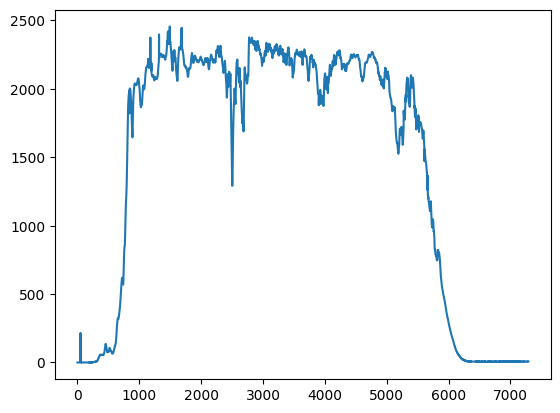

In [11]:
plt.plot(y)

In [12]:
X = data.drop(columns="nv")

In [13]:
X

,sec,hlon,hlat,earth_distance,radius,mag,a_dec,a_ra,sec2,sec5,hour,minute,second
0,9342,5.074145,9.098155e-07,1.016533,0.004577,-26.8,0.381977,1.956124,87272964,96.654022,2,35,42
1,9353,5.074147,9.098679e-07,1.016533,0.004577,-26.8,0.381977,1.956126,87478609,96.710909,2,35,53
2,9363,5.074149,9.099156e-07,1.016533,0.004577,-26.8,0.381977,1.956128,87665769,96.762596,2,36,3
3,9374,5.074151,9.099681e-07,1.016533,0.004577,-26.8,0.381977,1.956131,87871876,96.819420,2,36,14
4,9385,5.074153,9.100205e-07,1.016533,0.004577,-26.8,0.381976,1.956133,88078225,96.876210,2,36,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7286,89265,5.089536,1.233494e-06,1.016497,0.004577,-26.8,0.379630,1.972508,7968240225,298.772489,-1,47,45
7287,89275,5.089538,1.233527e-06,1.016497,0.004577,-26.8,0.379630,1.972510,7970025625,298.789223,-1,47,55
7288,89285,5.089540,1.233560e-06,1.016497,0.004577,-26.8,0.379630,1.972512,7971811225,298.805957,-1,48,5
7289,89296,5.089542,1.233596e-06,1.016497,0.004577,-26.8,0.379629,1.972514,7973775616,298.824363,-1,48,16


In [14]:
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [15]:
categories = [
    np.array(list(range(-1, 24))),
    np.array(list(range(60))),
]
ohe = OneHotEncoder(categories=categories)

In [16]:
ohe.fit(data[["hour", "minute"]],)

OneHotEncoder(categories=[array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23]),
                          array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])])

In [17]:
X = np.hstack(
    [
        data.drop(columns="nv").to_numpy(),
        ohe.fit_transform(data[["hour", "minute"]]).todense(),
    ]
)
y = data.nv
y = y.to_numpy()

In [18]:
# ss_x = StandardScaler()
# ss_y = StandardScaler()
# X = ss_x.fit_transform(X)
# y = ss_y.fit_transform(y.reshape(-1, 1))

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, shuffle=False, random_state=42)

In [20]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dt_b = dataset_train.shuffle(buffer_size=1024).batch(batch_size=512)
dataset_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
dv_b = dataset_val.batch(batch_size=256)
metrics = pd.DataFrame(columns=["model_name", "RMSE", "MAPE"])

2023-01-31 09:02:13.947847: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2023-01-31 09:02:13.947923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: laptop
2023-01-31 09:02:13.947939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: laptop
2023-01-31 09:02:13.948119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.108.3
2023-01-31 09:02:13.948166: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.78.1
2023-01-31 09:02:13.948182: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 525.78.1 does not match DSO version 510.108.3 -- cannot find working devices in this configuration
2023-01-31 09:02:13.

Linear regression

See elasticnet for reference

In [21]:
from math import pow

In [22]:
C = list(map(lambda x: pow(10, x), range(-3,4)))
C

[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

In [23]:
models = {f"linear_regression_l1{c_l1}_l2{c_l2}":{
    "model":keras.models.Sequential([
  keras.layers.Dense(
      1,
      kernel_regularizer=keras.regularizers.l1_l2(l1=c_l1, l2=c_l2))
]),
    "c_l1": c_l1,
    "c_l2": c_l2,
    "history": None
}
for c_l1 in C for c_l2 in C}

In [24]:
for batch in dataset_train.take(1):
    inputs, targets = batch
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (98,)
Target shape: ()


In [60]:
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError

model_folder = "linear_regression"
os.makedirs(model_folder, exist_ok=True)
for name, model_dict in models.items():
    model = model_dict["model"]
    model.build(input_shape=targets.shape)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.1**2),
        loss="mse",
        metrics=[
            RootMeanSquaredError(name="root_mean_squared_error", dtype=None),
            MeanAbsoluteError(name="mean_absolute_error", dtype=None),
        ],
    )
    path_checkpoint = f"{model_folder}/{name}.h5"

    es_callback = keras.callbacks.EarlyStopping(
        monitor="val_loss", min_delta=0, patience=10
    )
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
        monitor="val_loss",
        filepath=path_checkpoint,
        verbose=1,
        save_weights_only=True,
        save_best_only=True,
    )

    model_dict["history"] = model.fit(
        dt_b,
        epochs=10000,
        validation_data=dv_b,
        callbacks=[es_callback, modelckpt_callback],
        verbose=0
    )
    metrics = pd.concat([metrics, pd.DataFrame(
        {
            "model_name":name,
         "RMSE":model_dict["history"].history["val_root_mean_squared_error"][
            np.argmin(model_dict["history"].history["val_loss"])
        ], 
         "MAPE":model_dict["history"].history["val_mean_absolute_error"][
            np.argmin(model_dict["history"].history["val_loss"])]
        }, index=[0])])


Epoch 1: val_loss improved from inf to 61798208241664.00000, saving model to linear_regression/linear_regression_l10.001_l20.001.h5

Epoch 2: val_loss improved from 61798208241664.00000 to 85005279232.00000, saving model to linear_regression/linear_regression_l10.001_l20.001.h5

Epoch 3: val_loss did not improve from 85005279232.00000

Epoch 4: val_loss did not improve from 85005279232.00000

Epoch 5: val_loss did not improve from 85005279232.00000

Epoch 6: val_loss did not improve from 85005279232.00000

Epoch 7: val_loss did not improve from 85005279232.00000

Epoch 8: val_loss did not improve from 85005279232.00000

Epoch 9: val_loss did not improve from 85005279232.00000

Epoch 10: val_loss did not improve from 85005279232.00000

Epoch 11: val_loss did not improve from 85005279232.00000

Epoch 12: val_loss did not improve from 85005279232.00000

Epoch 1: val_loss improved from inf to 24674108964864.00000, saving model to linear_regression/linear_regression_l10.001_l20.01.h5

Epoc


Epoch 13: val_loss did not improve from 577847099392.00000

Epoch 14: val_loss improved from 577847099392.00000 to 249760923648.00000, saving model to linear_regression/linear_regression_l10.001_l2100.0.h5

Epoch 15: val_loss improved from 249760923648.00000 to 52338647040.00000, saving model to linear_regression/linear_regression_l10.001_l2100.0.h5

Epoch 16: val_loss improved from 52338647040.00000 to 48281120768.00000, saving model to linear_regression/linear_regression_l10.001_l2100.0.h5

Epoch 17: val_loss improved from 48281120768.00000 to 12718629888.00000, saving model to linear_regression/linear_regression_l10.001_l2100.0.h5

Epoch 18: val_loss improved from 12718629888.00000 to 2944103936.00000, saving model to linear_regression/linear_regression_l10.001_l2100.0.h5

Epoch 19: val_loss improved from 2944103936.00000 to 728054272.00000, saving model to linear_regression/linear_regression_l10.001_l2100.0.h5

Epoch 20: val_loss did not improve from 728054272.00000

Epoch 21: val


Epoch 5: val_loss did not improve from 339298020753408.00000

Epoch 6: val_loss improved from 339298020753408.00000 to 159438480605184.00000, saving model to linear_regression/linear_regression_l10.01_l21.0.h5

Epoch 7: val_loss did not improve from 159438480605184.00000

Epoch 8: val_loss improved from 159438480605184.00000 to 14634579918848.00000, saving model to linear_regression/linear_regression_l10.01_l21.0.h5

Epoch 9: val_loss did not improve from 14634579918848.00000

Epoch 10: val_loss improved from 14634579918848.00000 to 28126445568.00000, saving model to linear_regression/linear_regression_l10.01_l21.0.h5

Epoch 11: val_loss did not improve from 28126445568.00000

Epoch 12: val_loss did not improve from 28126445568.00000

Epoch 13: val_loss did not improve from 28126445568.00000

Epoch 14: val_loss did not improve from 28126445568.00000

Epoch 15: val_loss improved from 28126445568.00000 to 2047706880.00000, saving model to linear_regression/linear_regression_l10.01_l21.0


Epoch 2: val_loss did not improve from 941733185585152.00000

Epoch 3: val_loss did not improve from 941733185585152.00000

Epoch 4: val_loss did not improve from 941733185585152.00000

Epoch 5: val_loss improved from 941733185585152.00000 to 848148599668736.00000, saving model to linear_regression/linear_regression_l10.01_l21000.0.h5

Epoch 6: val_loss improved from 848148599668736.00000 to 570648494080.00000, saving model to linear_regression/linear_regression_l10.01_l21000.0.h5

Epoch 7: val_loss did not improve from 570648494080.00000

Epoch 8: val_loss did not improve from 570648494080.00000

Epoch 9: val_loss did not improve from 570648494080.00000

Epoch 10: val_loss improved from 570648494080.00000 to 221449846784.00000, saving model to linear_regression/linear_regression_l10.01_l21000.0.h5

Epoch 11: val_loss did not improve from 221449846784.00000

Epoch 12: val_loss did not improve from 221449846784.00000

Epoch 13: val_loss did not improve from 221449846784.00000

Epoch 14


Epoch 10: val_loss improved from 46128296886272.00000 to 27390935826432.00000, saving model to linear_regression/linear_regression_l10.1_l20.1.h5

Epoch 11: val_loss improved from 27390935826432.00000 to 666790723584.00000, saving model to linear_regression/linear_regression_l10.1_l20.1.h5

Epoch 12: val_loss did not improve from 666790723584.00000

Epoch 13: val_loss improved from 666790723584.00000 to 47931375616.00000, saving model to linear_regression/linear_regression_l10.1_l20.1.h5

Epoch 14: val_loss did not improve from 47931375616.00000

Epoch 15: val_loss improved from 47931375616.00000 to 21062180864.00000, saving model to linear_regression/linear_regression_l10.1_l20.1.h5

Epoch 16: val_loss did not improve from 21062180864.00000

Epoch 17: val_loss improved from 21062180864.00000 to 9997078528.00000, saving model to linear_regression/linear_regression_l10.1_l20.1.h5

Epoch 18: val_loss improved from 9997078528.00000 to 3113232384.00000, saving model to linear_regression/l


Epoch 3: val_loss improved from 194589420400148480.00000 to 11841076658700288.00000, saving model to linear_regression/linear_regression_l10.1_l2100.0.h5

Epoch 4: val_loss improved from 11841076658700288.00000 to 4683127112859648.00000, saving model to linear_regression/linear_regression_l10.1_l2100.0.h5

Epoch 5: val_loss did not improve from 4683127112859648.00000

Epoch 6: val_loss improved from 4683127112859648.00000 to 3347279004041216.00000, saving model to linear_regression/linear_regression_l10.1_l2100.0.h5

Epoch 7: val_loss improved from 3347279004041216.00000 to 49435664973824.00000, saving model to linear_regression/linear_regression_l10.1_l2100.0.h5

Epoch 8: val_loss did not improve from 49435664973824.00000

Epoch 9: val_loss did not improve from 49435664973824.00000

Epoch 10: val_loss improved from 49435664973824.00000 to 9133885489152.00000, saving model to linear_regression/linear_regression_l10.1_l2100.0.h5

Epoch 11: val_loss did not improve from 9133885489152.00


Epoch 23: val_loss did not improve from 1446579840.00000

Epoch 24: val_loss did not improve from 1446579840.00000

Epoch 1: val_loss improved from inf to 1292663957487616.00000, saving model to linear_regression/linear_regression_l11.0_l20.1.h5

Epoch 2: val_loss improved from 1292663957487616.00000 to 61170396430336.00000, saving model to linear_regression/linear_regression_l11.0_l20.1.h5

Epoch 3: val_loss did not improve from 61170396430336.00000

Epoch 4: val_loss did not improve from 61170396430336.00000

Epoch 5: val_loss did not improve from 61170396430336.00000

Epoch 6: val_loss did not improve from 61170396430336.00000

Epoch 7: val_loss did not improve from 61170396430336.00000

Epoch 8: val_loss did not improve from 61170396430336.00000

Epoch 9: val_loss did not improve from 61170396430336.00000

Epoch 10: val_loss did not improve from 61170396430336.00000

Epoch 11: val_loss improved from 61170396430336.00000 to 8011734056960.00000, saving model to linear_regression/lin


Epoch 6: val_loss improved from 889378473771008.00000 to 44272841654272.00000, saving model to linear_regression/linear_regression_l11.0_l2100.0.h5

Epoch 7: val_loss did not improve from 44272841654272.00000

Epoch 8: val_loss did not improve from 44272841654272.00000

Epoch 9: val_loss improved from 44272841654272.00000 to 685255229440.00000, saving model to linear_regression/linear_regression_l11.0_l2100.0.h5

Epoch 10: val_loss did not improve from 685255229440.00000

Epoch 11: val_loss did not improve from 685255229440.00000

Epoch 12: val_loss did not improve from 685255229440.00000

Epoch 13: val_loss did not improve from 685255229440.00000

Epoch 14: val_loss improved from 685255229440.00000 to 12512182272.00000, saving model to linear_regression/linear_regression_l11.0_l2100.0.h5

Epoch 15: val_loss did not improve from 12512182272.00000

Epoch 16: val_loss improved from 12512182272.00000 to 2740079360.00000, saving model to linear_regression/linear_regression_l11.0_l2100.0.h


Epoch 19: val_loss did not improve from 1812102.37500

Epoch 20: val_loss did not improve from 1812102.37500

Epoch 21: val_loss did not improve from 1812102.37500

Epoch 22: val_loss did not improve from 1812102.37500

Epoch 23: val_loss did not improve from 1812102.37500

Epoch 24: val_loss did not improve from 1812102.37500

Epoch 25: val_loss did not improve from 1812102.37500

Epoch 26: val_loss did not improve from 1812102.37500

Epoch 27: val_loss did not improve from 1812102.37500

Epoch 28: val_loss did not improve from 1812102.37500

Epoch 1: val_loss improved from inf to 7062721396736.00000, saving model to linear_regression/linear_regression_l110.0_l20.1.h5

Epoch 2: val_loss did not improve from 7062721396736.00000

Epoch 3: val_loss did not improve from 7062721396736.00000

Epoch 4: val_loss did not improve from 7062721396736.00000

Epoch 5: val_loss did not improve from 7062721396736.00000

Epoch 6: val_loss did not improve from 7062721396736.00000

Epoch 7: val_loss di


Epoch 7: val_loss did not improve from 342741343010816.00000

Epoch 8: val_loss did not improve from 342741343010816.00000

Epoch 9: val_loss did not improve from 342741343010816.00000

Epoch 10: val_loss improved from 342741343010816.00000 to 160261302386688.00000, saving model to linear_regression/linear_regression_l110.0_l2100.0.h5

Epoch 11: val_loss improved from 160261302386688.00000 to 3955747979264.00000, saving model to linear_regression/linear_regression_l110.0_l2100.0.h5

Epoch 12: val_loss did not improve from 3955747979264.00000

Epoch 13: val_loss did not improve from 3955747979264.00000

Epoch 14: val_loss did not improve from 3955747979264.00000

Epoch 15: val_loss did not improve from 3955747979264.00000

Epoch 16: val_loss improved from 3955747979264.00000 to 3944245362688.00000, saving model to linear_regression/linear_regression_l110.0_l2100.0.h5

Epoch 17: val_loss improved from 3944245362688.00000 to 2072115412992.00000, saving model to linear_regression/linear_r


Epoch 6: val_loss did not improve from 136232268988416.00000

Epoch 7: val_loss improved from 136232268988416.00000 to 25589358592.00000, saving model to linear_regression/linear_regression_l1100.0_l20.01.h5

Epoch 8: val_loss did not improve from 25589358592.00000

Epoch 9: val_loss did not improve from 25589358592.00000

Epoch 10: val_loss did not improve from 25589358592.00000

Epoch 11: val_loss did not improve from 25589358592.00000

Epoch 12: val_loss did not improve from 25589358592.00000

Epoch 13: val_loss improved from 25589358592.00000 to 11016772608.00000, saving model to linear_regression/linear_regression_l1100.0_l20.01.h5

Epoch 14: val_loss did not improve from 11016772608.00000

Epoch 15: val_loss did not improve from 11016772608.00000

Epoch 16: val_loss did not improve from 11016772608.00000

Epoch 17: val_loss did not improve from 11016772608.00000

Epoch 18: val_loss improved from 11016772608.00000 to 653716608.00000, saving model to linear_regression/linear_regre


Epoch 1: val_loss improved from inf to 803889784706564096.00000, saving model to linear_regression/linear_regression_l1100.0_l210.0.h5

Epoch 2: val_loss improved from 803889784706564096.00000 to 213194531531653120.00000, saving model to linear_regression/linear_regression_l1100.0_l210.0.h5

Epoch 3: val_loss improved from 213194531531653120.00000 to 15682491113275392.00000, saving model to linear_regression/linear_regression_l1100.0_l210.0.h5

Epoch 4: val_loss improved from 15682491113275392.00000 to 3560481985921024.00000, saving model to linear_regression/linear_regression_l1100.0_l210.0.h5

Epoch 5: val_loss did not improve from 3560481985921024.00000

Epoch 6: val_loss did not improve from 3560481985921024.00000

Epoch 7: val_loss improved from 3560481985921024.00000 to 125144131436544.00000, saving model to linear_regression/linear_regression_l1100.0_l210.0.h5

Epoch 8: val_loss did not improve from 125144131436544.00000

Epoch 9: val_loss did not improve from 125144131436544.0


Epoch 4: val_loss improved from 2609656102912.00000 to 247947198464.00000, saving model to linear_regression/linear_regression_l11000.0_l20.001.h5

Epoch 5: val_loss did not improve from 247947198464.00000

Epoch 6: val_loss did not improve from 247947198464.00000

Epoch 7: val_loss did not improve from 247947198464.00000

Epoch 8: val_loss improved from 247947198464.00000 to 1389740928.00000, saving model to linear_regression/linear_regression_l11000.0_l20.001.h5

Epoch 9: val_loss did not improve from 1389740928.00000

Epoch 10: val_loss did not improve from 1389740928.00000

Epoch 11: val_loss did not improve from 1389740928.00000

Epoch 12: val_loss did not improve from 1389740928.00000

Epoch 13: val_loss did not improve from 1389740928.00000

Epoch 14: val_loss did not improve from 1389740928.00000

Epoch 15: val_loss did not improve from 1389740928.00000

Epoch 16: val_loss did not improve from 1389740928.00000

Epoch 17: val_loss did not improve from 1389740928.00000

Epoch 18


Epoch 1: val_loss improved from inf to 2820482474704896.00000, saving model to linear_regression/linear_regression_l11000.0_l210.0.h5

Epoch 2: val_loss did not improve from 2820482474704896.00000

Epoch 3: val_loss improved from 2820482474704896.00000 to 307492378640384.00000, saving model to linear_regression/linear_regression_l11000.0_l210.0.h5

Epoch 4: val_loss did not improve from 307492378640384.00000

Epoch 5: val_loss did not improve from 307492378640384.00000

Epoch 6: val_loss improved from 307492378640384.00000 to 44770390966272.00000, saving model to linear_regression/linear_regression_l11000.0_l210.0.h5

Epoch 7: val_loss did not improve from 44770390966272.00000

Epoch 8: val_loss improved from 44770390966272.00000 to 30534963036160.00000, saving model to linear_regression/linear_regression_l11000.0_l210.0.h5

Epoch 9: val_loss improved from 30534963036160.00000 to 32914458624.00000, saving model to linear_regression/linear_regression_l11000.0_l210.0.h5

Epoch 10: val_l


Epoch 32: val_loss improved from 190404.06250 to 190151.68750, saving model to linear_regression/linear_regression_l11000.0_l21000.0.h5

Epoch 33: val_loss did not improve from 190151.68750

Epoch 34: val_loss did not improve from 190151.68750

Epoch 35: val_loss did not improve from 190151.68750

Epoch 36: val_loss did not improve from 190151.68750

Epoch 37: val_loss did not improve from 190151.68750

Epoch 38: val_loss did not improve from 190151.68750

Epoch 39: val_loss did not improve from 190151.68750

Epoch 40: val_loss did not improve from 190151.68750

Epoch 41: val_loss did not improve from 190151.68750

Epoch 42: val_loss did not improve from 190151.68750


In [25]:
metrics.reset_index(drop=True, inplace=True)

In [26]:
metrics

,model_name,RMSE,MAPE


# Tree methods

### Tensorflow Decision Forests

Following code on my notebook just get exception, however it should work on other device (I have problems with nvidia cuda and therefore with tensorflow)

In [28]:
# import tensorflow_decision_forests as tfdf
# # Train a Random Forest model.
# tuner = tfdf.tuner.RandomSearch(num_trials=2)

# # Hyper-parameters to optimize.
# tuner.choice("max_depth", [4, 5, 6, 7])

In [29]:
# rf = tfdf.keras.RandomForestModel()
# rf.fit(
#     dataset_train.batch(512),
#     validation_data=dataset_val.batch(512),
# #     tuner=tuner,
# )

# # Summary of the model structure.
# rf.summary()

# # Evaluate the model.
# # rf.evaluate(dataset_val)

# # Export the model to a SavedModel.
# rf.save("random_forest.h5")

In [ ]:
# gbt = tfdf.keras.GradientBoostedTreesModel()
# gbt.fit(
#     dataset_train.batch(512),
#     validation_data=dataset_val.batch(512),
# #     tuner=tuner,
# )

# gbt.save("GradientBoostedTreesModel.h5")

Use /tmp/tmp32drw_d1 as temporary training directory
Reading training dataset...
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Training dataset read in 0:00:03.847967. Found 4884 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(2407, shape=(), dtype=int32)
Validation dataset read in 0:00:00.660527. Found 2407 examples.
Training model...


2023-01-31 08:56:01.999750: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-01-31 08:56:01.999782: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-01-31 08:56:01.999790: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-01-31 08:56:02.003503: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:452] Default loss set to MULTINOMIAL_LOG_LIKELIHOOD
2023-01-31 08:56:02.003669: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:484] The model configuration specifies 300 trees but computation of the validation loss will

### Xgboost
https://stackoverflow.com/questions/40418612/xgboost-on-android

In [26]:
import xgboost as xgb


In [65]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE
 
# Train and test set are converted to DMatrix objects,
# as it is required by learning API.
train_dmatrix = xgb.DMatrix(data = X_train, label = y_train)
val_dmatrix = xgb.DMatrix(data = X_val, label = y_val)
  
# Parameter dictionary specifying base learner

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
       'booster': hp.choice('booster', ['gbtree', 'dart','gblinear']),
        'reg_alpha' : hp.choice('reg_alpha', list(map(lambda x: pow(10, x), range(-4,5)))),
        'reg_lambda' : hp.choice('reg_lambda', list(map(lambda x: pow(10, x), range(-4,5)))),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         'n_estimators': hp.choice([10,50,100,150,200]),
       'objective':hp.choice('objective', ['reg:squarederror', 'reg:squaredlogerror', 'reg:absoluteerror', 'reg:pseudohubererror', 'reg:tweedie']),
    }
def objective(space):
    evaluation = [( X_train, y_train), ( X_val, y_val)]
    clf=xgb.XGBRegressor(
        booster = space['booster'],
        objective = space['objective'],
#                     n_estimators =space['n_estimators'],
        max_depth = int(space['max_depth']), 
#         gamma = space['gamma'],
        reg_lambda = space['reg_lambda'],
        reg_alpha = int(space['reg_alpha']),
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=int(space['colsample_bytree']),
        early_stopping_rounds=4,
        seed=42,
                    eval_metric="rmse",

    )
    
    
    clf.fit(X_train, y_train,
                    eval_set=evaluation,

            verbose=True)
    pred = clf.predict(X_val)
    try:
        rmse = np.sqrt(MSE(y_val, pred))
    except ValueError:
        rmse = 10**5
    print ("SCORE:", rmse)
    return {'loss': rmse, 'status': STATUS_OK }


In [66]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

[0]	validation_0-rmse:1980.60541	validation_1-rmse:1091.03134                   
[1]	validation_0-rmse:1809.25879	validation_1-rmse:980.10885                    
[2]	validation_0-rmse:1809.25879	validation_1-rmse:980.10885                    
[3]	validation_0-rmse:1809.25879	validation_1-rmse:980.10885                    
[4]	validation_0-rmse:1809.25879	validation_1-rmse:980.10885                    
[5]	validation_0-rmse:1809.25879	validation_1-rmse:980.10885                    
SCORE:                                                                          
980.1088530749051                                                               
[09:49:18] WARNING: ../src/learner.cc:767:                                      
Parameters: { "colsample_bytree", "max_depth", "min_child_weight" } are not used.

[0]	validation_0-rmse:1985.81385	validation_1-rmse:1093.67715                   
[1]	validation_0-rmse:1963.69436	validation_1-rmse:1060.64838                   
[2]	validation_0-rmse:1797

[82]	validation_0-rmse:805.24952	validation_1-rmse:1968.20576                   
[83]	validation_0-rmse:805.11837	validation_1-rmse:1967.56652                   
[84]	validation_0-rmse:804.98568	validation_1-rmse:1966.92674                   
[85]	validation_0-rmse:804.85172	validation_1-rmse:1966.28545                   
[86]	validation_0-rmse:804.71689	validation_1-rmse:1965.64182                   
[87]	validation_0-rmse:804.58146	validation_1-rmse:1964.99475                   
[88]	validation_0-rmse:804.44570	validation_1-rmse:1964.34303                   
[89]	validation_0-rmse:804.30998	validation_1-rmse:1963.68636                   
[90]	validation_0-rmse:804.17446	validation_1-rmse:1963.02398                   
[91]	validation_0-rmse:804.03945	validation_1-rmse:1962.35640                   
[92]	validation_0-rmse:803.90496	validation_1-rmse:1961.68374                   
[93]	validation_0-rmse:803.77113	validation_1-rmse:1961.00729                   
[94]	validation_0-rmse:803.6

[63]	validation_0-rmse:1967.59516	validation_1-rmse:1081.94295                  
[64]	validation_0-rmse:1967.42136	validation_1-rmse:1081.82226                  
[65]	validation_0-rmse:1967.24955	validation_1-rmse:1081.70285                  
[66]	validation_0-rmse:1967.07936	validation_1-rmse:1081.58470                  
[67]	validation_0-rmse:1966.91097	validation_1-rmse:1081.46781                  
[68]	validation_0-rmse:1966.74435	validation_1-rmse:1081.35206                  
[69]	validation_0-rmse:1966.57933	validation_1-rmse:1081.23749                  
[70]	validation_0-rmse:1966.41609	validation_1-rmse:1081.12411                  
[71]	validation_0-rmse:1966.25423	validation_1-rmse:1081.01182                  
[72]	validation_0-rmse:1966.09394	validation_1-rmse:1080.90058                  
[73]	validation_0-rmse:1965.93524	validation_1-rmse:1080.79045                  
[74]	validation_0-rmse:1965.77790	validation_1-rmse:1080.68134                  
[75]	validation_0-rmse:1965.

[2]	validation_0-rmse:1981.19733	validation_1-rmse:1090.55719                   
[3]	validation_0-rmse:1973.87235	validation_1-rmse:1084.21033                   
[4]	validation_0-rmse:1960.94080	validation_1-rmse:1072.74305                   
[5]	validation_0-rmse:1938.68264	validation_1-rmse:1052.72984                   
[6]	validation_0-rmse:1901.65791	validation_1-rmse:1020.03043                   
[7]	validation_0-rmse:1842.87898	validation_1-rmse:972.45249                    
[8]	validation_0-rmse:1754.38241	validation_1-rmse:917.85124                    
[9]	validation_0-rmse:1629.49939	validation_1-rmse:895.90423                    
[10]	validation_0-rmse:1467.06972	validation_1-rmse:993.29452                   
[11]	validation_0-rmse:1279.70682	validation_1-rmse:1286.70556                  
[12]	validation_0-rmse:1096.47451	validation_1-rmse:1766.70234                  
SCORE:                                                                          
2279.4283236674864          

[0]	validation_0-rmse:833.72655	validation_1-rmse:1681.94714                    
[1]	validation_0-rmse:833.73891	validation_1-rmse:1682.27905                    
[2]	validation_0-rmse:833.75140	validation_1-rmse:1682.61119                    
[3]	validation_0-rmse:833.76381	validation_1-rmse:1682.94313                    
SCORE:                                                                          
1683.2752675928155                                                              
[09:49:30] WARNING: ../src/learner.cc:767:                                      
Parameters: { "colsample_bytree", "max_depth", "min_child_weight" } are not used.

[0]	validation_0-rmse:1987.75088	validation_1-rmse:1095.79351                   
[1]	validation_0-rmse:1986.09792	validation_1-rmse:1094.11699                   
[2]	validation_0-rmse:1983.37702	validation_1-rmse:1091.27682                   
[3]	validation_0-rmse:1979.12369	validation_1-rmse:1086.67714                   
[4]	validation_0-rmse:1973

[10]	validation_0-rmse:1725.07810	validation_1-rmse:934.79816                   
[11]	validation_0-rmse:1580.64015	validation_1-rmse:873.13212                   
[12]	validation_0-rmse:1402.31201	validation_1-rmse:833.44668                   
[13]	validation_0-rmse:1211.25482	validation_1-rmse:844.52537                   
[14]	validation_0-rmse:1033.31027	validation_1-rmse:908.76722                   
[15]	validation_0-rmse:887.17463	validation_1-rmse:1001.74920                   
SCORE:                                                                          
833.446682206818                                                                
[0]	validation_0-rmse:1988.34265	validation_1-rmse:1096.48149                   
[1]	validation_0-rmse:1987.65180	validation_1-rmse:1095.99353                   
[2]	validation_0-rmse:1986.39533	validation_1-rmse:1095.10662                   
[3]	validation_0-rmse:1984.11308	validation_1-rmse:1093.49807                   
[4]	validation_0-rmse:1979.9

[8]	validation_0-rmse:1895.08003	validation_1-rmse:1033.26000                   
[9]	validation_0-rmse:1828.23231	validation_1-rmse:991.72271                    
[10]	validation_0-rmse:1725.07810	validation_1-rmse:934.79816                   
[11]	validation_0-rmse:1580.64015	validation_1-rmse:873.13212                   
[12]	validation_0-rmse:1402.31201	validation_1-rmse:833.44668                   
[13]	validation_0-rmse:1211.25482	validation_1-rmse:844.52537                   
[14]	validation_0-rmse:1033.31027	validation_1-rmse:908.76722                   
[15]	validation_0-rmse:887.17463	validation_1-rmse:1001.74920                   
[16]	validation_0-rmse:779.10791	validation_1-rmse:1095.56330                   
SCORE:                                                                          
833.446682206818                                                                
[0]	validation_0-rmse:1494.39216	validation_1-rmse:846.84912                    
[1]	validation_0-rmse:1178.7

833.4461153032241                                                               
[0]	validation_0-rmse:1980.54473	validation_1-rmse:1091.00885                   
[1]	validation_0-rmse:1770.91307	validation_1-rmse:958.31440                    
[2]	validation_0-rmse:1770.91307	validation_1-rmse:958.31440                    
[3]	validation_0-rmse:1770.91307	validation_1-rmse:958.31440                    
[4]	validation_0-rmse:1770.91307	validation_1-rmse:958.31440                    
SCORE:                                                                          
958.3143735557463                                                               
[0]	validation_0-rmse:1988.34265	validation_1-rmse:1096.48149                   
[1]	validation_0-rmse:1987.65178	validation_1-rmse:1095.99348                   
[2]	validation_0-rmse:1986.39512	validation_1-rmse:1095.10653                   
[3]	validation_0-rmse:1984.11284	validation_1-rmse:1093.49785                   
[4]	validation_0-rmse:1979.9

[12]	validation_0-rmse:1441.35293	validation_1-rmse:837.86371                   
[13]	validation_0-rmse:1263.42219	validation_1-rmse:836.32008                   
[14]	validation_0-rmse:1094.63483	validation_1-rmse:884.49966                   
[15]	validation_0-rmse:952.55795	validation_1-rmse:965.12121                    
[16]	validation_0-rmse:844.78186	validation_1-rmse:1054.72340                   
SCORE:                                                                          
836.3200869656088                                                               
[0]	validation_0-rmse:1988.34291	validation_1-rmse:1096.48177                   
[1]	validation_0-rmse:1987.65338	validation_1-rmse:1095.99465                   
[2]	validation_0-rmse:1986.40054	validation_1-rmse:1095.11041                   
[3]	validation_0-rmse:1984.12862	validation_1-rmse:1093.50897                   
[4]	validation_0-rmse:1980.02114	validation_1-rmse:1090.62109                   
[5]	validation_0-rmse:1972.6

[8]	validation_0-rmse:1896.83481	validation_1-rmse:1034.37672                   
[9]	validation_0-rmse:1832.22332	validation_1-rmse:993.97025                    
[10]	validation_0-rmse:1733.50779	validation_1-rmse:938.80330                   
[11]	validation_0-rmse:1596.74745	validation_1-rmse:878.35758                   
[12]	validation_0-rmse:1429.58245	validation_1-rmse:836.19653                   
[13]	validation_0-rmse:1251.94360	validation_1-rmse:838.03697                   
[14]	validation_0-rmse:1087.37001	validation_1-rmse:887.77298                   
[15]	validation_0-rmse:952.31473	validation_1-rmse:965.45734                    
SCORE:                                                                          
836.1965394926938                                                               
[0]	validation_0-rmse:1988.36160	validation_1-rmse:1096.49488                   
[1]	validation_0-rmse:1987.90960	validation_1-rmse:1096.17561                   
[2]	validation_0-rmse:1987.3

[1]	validation_0-rmse:1985.59593	validation_1-rmse:1093.80041                   
[2]	validation_0-rmse:1982.15622	validation_1-rmse:1090.26760                   
[3]	validation_0-rmse:1976.29830	validation_1-rmse:1084.26250                   
[4]	validation_0-rmse:1966.82730	validation_1-rmse:1074.55588                   
[5]	validation_0-rmse:1951.14589	validation_1-rmse:1058.75782                   
[6]	validation_0-rmse:1925.48305	validation_1-rmse:1033.88634                   
[7]	validation_0-rmse:1884.55647	validation_1-rmse:997.30912                    
[8]	validation_0-rmse:1821.28722	validation_1-rmse:950.12685                    
[9]	validation_0-rmse:1727.47849	validation_1-rmse:907.31642                    
[10]	validation_0-rmse:1596.44342	validation_1-rmse:917.89386                   
[11]	validation_0-rmse:1429.09825	validation_1-rmse:1069.88899                  
[12]	validation_0-rmse:1242.47114	validation_1-rmse:1423.50811                  
SCORE:                      

[7]	validation_0-rmse:1936.98190	validation_1-rmse:1060.97103                   
[8]	validation_0-rmse:1898.29689	validation_1-rmse:1035.32667                   
[9]	validation_0-rmse:1835.28982	validation_1-rmse:995.81740                    
[10]	validation_0-rmse:1739.24688	validation_1-rmse:941.77156                   
[11]	validation_0-rmse:1605.89345	validation_1-rmse:881.74092                   
[12]	validation_0-rmse:1441.35990	validation_1-rmse:837.86230                   
[13]	validation_0-rmse:1263.44574	validation_1-rmse:836.32153                   
[14]	validation_0-rmse:1094.68679	validation_1-rmse:884.50401                   
[15]	validation_0-rmse:952.64925	validation_1-rmse:965.12735                    
[16]	validation_0-rmse:844.91990	validation_1-rmse:1054.72979                   
[17]	validation_0-rmse:770.04261	validation_1-rmse:1137.71386                   
SCORE:                                                                          
836.3215304368897           

[7]	validation_0-rmse:1935.60683	validation_1-rmse:1060.04837                   
[8]	validation_0-rmse:1895.09279	validation_1-rmse:1033.27062                   
[9]	validation_0-rmse:1828.27158	validation_1-rmse:991.67539                    
[10]	validation_0-rmse:1725.18288	validation_1-rmse:934.74662                   
[11]	validation_0-rmse:1580.89360	validation_1-rmse:873.09481                   
[12]	validation_0-rmse:1402.85282	validation_1-rmse:833.44075                   
[13]	validation_0-rmse:1212.26327	validation_1-rmse:844.54117                   
[14]	validation_0-rmse:1034.96456	validation_1-rmse:908.75979                   
[15]	validation_0-rmse:889.59852	validation_1-rmse:1001.65820                   
[16]	validation_0-rmse:782.32765	validation_1-rmse:1095.37621                   
SCORE:                                                                          
833.440754826663                                                                
[0]	validation_0-rmse:1988.3

[14]	validation_0-rmse:1033.31334	validation_1-rmse:908.76883                   
[15]	validation_0-rmse:887.17818	validation_1-rmse:1001.75086                   
[16]	validation_0-rmse:779.11121	validation_1-rmse:1095.56442                   
SCORE:                                                                          
833.4464811742203                                                               
[0]	validation_0-rmse:1982.33236	validation_1-rmse:1092.24484                   
[1]	validation_0-rmse:1921.07273	validation_1-rmse:1050.26550                   
[2]	validation_0-rmse:1792.47167	validation_1-rmse:970.40432                    
[3]	validation_0-rmse:1792.47167	validation_1-rmse:970.40432                    
[4]	validation_0-rmse:1792.47167	validation_1-rmse:970.40432                    
[5]	validation_0-rmse:1792.47167	validation_1-rmse:970.40432                    
SCORE:                                                                          
970.4043167326206           

[12]	validation_0-rmse:1451.11047	validation_1-rmse:838.46888                   
[13]	validation_0-rmse:1281.80781	validation_1-rmse:835.45110                   
[14]	validation_0-rmse:1125.15602	validation_1-rmse:880.56389                   
[15]	validation_0-rmse:997.73616	validation_1-rmse:957.24396                    
[16]	validation_0-rmse:905.28962	validation_1-rmse:1042.90875                   
SCORE:                                                                          
835.4510902517811                                                               
[0]	validation_0-rmse:1980.73163	validation_1-rmse:1091.12000                   
[1]	validation_0-rmse:1792.43827	validation_1-rmse:970.38526                    
[2]	validation_0-rmse:1792.43827	validation_1-rmse:970.38526                    
[3]	validation_0-rmse:1792.43827	validation_1-rmse:970.38526                    
[4]	validation_0-rmse:1792.43827	validation_1-rmse:970.38526                    
[5]	validation_0-rmse:1792.4

[86]	validation_0-rmse:1962.77585	validation_1-rmse:1078.60114                  
[87]	validation_0-rmse:1962.61993	validation_1-rmse:1078.49335                  
[88]	validation_0-rmse:1962.46530	validation_1-rmse:1078.38631                  
[89]	validation_0-rmse:1962.31161	validation_1-rmse:1078.28004                  
[90]	validation_0-rmse:1962.15903	validation_1-rmse:1078.17450                  
[91]	validation_0-rmse:1962.00756	validation_1-rmse:1078.06969                  
[92]	validation_0-rmse:1961.85711	validation_1-rmse:1077.96565                  
[93]	validation_0-rmse:1961.70760	validation_1-rmse:1077.86232                  
[94]	validation_0-rmse:1961.55908	validation_1-rmse:1077.75964                  
[95]	validation_0-rmse:1961.41166	validation_1-rmse:1077.65769                  
[96]	validation_0-rmse:1961.26514	validation_1-rmse:1077.55636                  
[97]	validation_0-rmse:1961.11937	validation_1-rmse:1077.45573                  
[98]	validation_0-rmse:1960.

[13]	validation_0-rmse:1962.03158	validation_1-rmse:1078.08743                  
[14]	validation_0-rmse:1955.70703	validation_1-rmse:1073.72574                  
[15]	validation_0-rmse:1948.11308	validation_1-rmse:1068.51992                  
[16]	validation_0-rmse:1939.05640	validation_1-rmse:1062.35697                  
[17]	validation_0-rmse:1928.34184	validation_1-rmse:1055.13131                  
[18]	validation_0-rmse:1928.34184	validation_1-rmse:1055.13131                  
[19]	validation_0-rmse:1928.34184	validation_1-rmse:1055.13131                  
[20]	validation_0-rmse:1928.34184	validation_1-rmse:1055.13131                  
SCORE:                                                                          
1055.131315277635                                                               
[0]	validation_0-rmse:1988.34265	validation_1-rmse:1096.48149                   
[1]	validation_0-rmse:1987.65178	validation_1-rmse:1095.99348                   
[2]	validation_0-rmse:1986.3

[2]	validation_0-rmse:1546.54953	validation_1-rmse:860.61614                    
[3]	validation_0-rmse:1432.63596	validation_1-rmse:835.77884                    
[4]	validation_0-rmse:1332.89286	validation_1-rmse:831.05919                    
[5]	validation_0-rmse:1245.95205	validation_1-rmse:841.45594                    
[6]	validation_0-rmse:1170.53804	validation_1-rmse:862.33611                    
[7]	validation_0-rmse:1105.45716	validation_1-rmse:889.87108                    
SCORE:                                                                          
831.0591956717094                                                               
[0]	validation_0-rmse:1822.91733	validation_1-rmse:988.17583                    
[1]	validation_0-rmse:1676.10938	validation_1-rmse:910.21782                    
[2]	validation_0-rmse:1546.54953	validation_1-rmse:860.61614                    
[3]	validation_0-rmse:1432.63596	validation_1-rmse:835.77884                    
[4]	validation_0-rmse:1332.8

In [67]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'booster': 0, 'colsample_bytree': 0.9983166182439028, 'max_depth': 12.0, 'min_child_weight': 10.0, 'objective': 0, 'reg_alpha': 3, 'reg_lambda': 8}


In [81]:
best_params ={
    'max_depth': int(best_hyperparams['max_depth']),
       'booster': ['gbtree', 'dart','gblinear'][best_hyperparams['booster']],
        'reg_alpha' : list(map(lambda x: pow(10, x), range(-4,5)))[best_hyperparams['reg_alpha']],
        'reg_lambda' : list(map(lambda x: pow(10, x), range(-4,5)))[best_hyperparams['reg_lambda']],
        'colsample_bytree' : int(best_hyperparams['colsample_bytree']),
        'min_child_weight' : int(best_hyperparams['min_child_weight']),
#         'n_estimators': hp.choice([10,50,100,150,200]),
       'objective':['reg:squarederror', 'reg:squaredlogerror', 'reg:absoluteerror', 'reg:pseudohubererror', 'reg:tweedie'][best_hyperparams['objective']],
    }

In [87]:
best_params = {'max_depth': 12,
 'booster': 'gbtree',
 'reg_alpha': 0.1,
 'reg_lambda': 10000.0,
 'colsample_bytree': 0,
 'min_child_weight': 10,
 'objective': 'reg:squarederror'}

{'max_depth': 12,
 'booster': 'gbtree',
 'reg_alpha': 0.1,
 'reg_lambda': 10000.0,
 'colsample_bytree': 0,
 'min_child_weight': 10,
 'objective': 'reg:squarederror'}

In [85]:
xgb_best = xgb.XGBRegressor(**best_params, early_stopping_rounds=6,
        seed=142,
                    eval_metric="rmse",)
xgb_best.fit(X_train, y_train,
                    eval_set=[( X_train, y_train), ( X_val, y_val)],

            verbose=True)
pred = xgb_best.predict(X_val)

# RMSE Computation
rmse = np.sqrt(MSE(y_val, pred))
print("RMSE : % f" %(rmse))



[0]	validation_0-rmse:1822.91733	validation_1-rmse:988.17583
[1]	validation_0-rmse:1676.10938	validation_1-rmse:910.21782
[2]	validation_0-rmse:1546.54953	validation_1-rmse:860.61613
[3]	validation_0-rmse:1432.63596	validation_1-rmse:835.77884
[4]	validation_0-rmse:1332.89287	validation_1-rmse:831.05919
[5]	validation_0-rmse:1245.95205	validation_1-rmse:841.45593
[6]	validation_0-rmse:1166.54205	validation_1-rmse:863.08766
[7]	validation_0-rmse:1101.26990	validation_1-rmse:890.86228
[8]	validation_0-rmse:1045.21743	validation_1-rmse:922.33003
[9]	validation_0-rmse:997.33934	validation_1-rmse:955.41146
RMSE :  831.059194


In [86]:
xgb_best.save_model('xgboost_best.json')

## Old models

In [ ]:
sequence_length = 6
dataset_train = keras.utils.timeseries_dataset_from_array(
    data=X_train,
    targets=y_train,
    sequence_length=sequence_length,
    batch_size=1024,
)
dataset_val = keras.utils.timeseries_dataset_from_array(
    data=X_val,
    targets=y_val,
    sequence_length=sequence_length,
    batch_size=1024,
)

In [ ]:
for batch in dataset_train.take(1):
    inputs, targets = batch
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

In [ ]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1**2), loss="mse")
model.summary()

In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=100,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [ ]:
# with open(file="Standart_Scaler_X.pckl", mode='wb') as f:
#     pickle.dump(obj=ss_x, file=f)
# with open(file="Standart_Scaler_y.pckl", mode='wb') as f:
#     pickle.dump(obj=ss_y, file=f)

In [ ]:
import pickle
import pandas as pd
import numpy as np
import keras
import ephem
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler

# with open(file="Standart_Scaler_X.pckl", mode='rb') as f:
#     Standart_Scaler_X = pickle.load(f)
# with open(file="Standart_Scaler_y.pckl", mode='rb') as f:
#     Standart_Scaler_y = pickle.load(f)

In [ ]:
def predict(sec:int, year:int, month:int, day:int, sequence_length:int, model):
    """input: 
        sec - number of sec from day beginning
        year:int, month:int, day:int
        
        output 
    """
    ### Ephem 
    LAT, LON = 55.775588, 37.605662 # latitude, longitude
    observer = ephem.Observer()
    observer.lat = LAT
    observer.lon = LON
    observer.date = datetime(year=year, month=month, day=day)
    sun = ephem.Sun(observer)
    
    features = ['hlon', 'hlat', 'earth_distance', 'phase', 'radius']
    data = pd.DataFrame({'nv':[0]*sequence_length, 'sec':[sec]*sequence_length})
    
    # Generate X data:
    for i in features:
        data[i] = np.nan
    for i, row in enumerate(data.iterrows()):
        sun.compute(observer.date.datetime()+timedelta(seconds=int(data.sec[i])))
        for feature in features:
            data.loc[i, feature] = sun.__getattribute__(feature)
    y = data.nv
    X = data.drop(columns="nv")
    X = X.to_numpy()
    y = y.to_numpy()
#     X = Standart_Scaler_X.transform(X)
    if sequence_length==1:
        y_pred = model.predict(X.reshape(-1, 6))
    else:
        y_pred = model.predict(X.reshape(1,sequence_length,6))
#     y_pred = Standart_Scaler_y.inverse_transform(y_pred)
    return y_pred

In [ ]:
predict(sec=29254, year=2021, month=7, day=13, sequence_length=6, model=model)

In [ ]:
# def show_plot(plot_data, delta, title):
#     labels = ["History", "True Future", "Model Prediction"]
#     marker = [".-", "rx", "go"]
#     time_steps = list(range(-(plot_data[0].shape[0]), 0))
#     if delta:
#         future = delta
#     else:
#         future = 0

#     plt.title(title)
#     for i, val in enumerate(plot_data):
#         if i:
#             plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
#         else:
#             plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
#     plt.legend()
#     plt.xlim([time_steps[0], (future + 5) * 2])
#     plt.xlabel("Time-Step")
#     plt.show()
#     return


# for x, y in dataset_val.take(5):
#     show_plot(
#         [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
#         12,
#         "Single Step Prediction",
#     )

In [ ]:
# Simple model

In [ ]:
import tensorflow as tf

In [ ]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_train = dataset_train.shuffle(256*3).batch(1, drop_remainder=True)
dataset_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
dataset_val = dataset_val.batch(1, drop_remainder=True)

In [ ]:
# sequence_length = 1
# dataset_train = keras.utils.timeseries_dataset_from_array(
#     data=X_train,
#     targets=y_train,
#     sequence_length=sequence_length,
#     batch_size=1024,
# )
# dataset_val = keras.utils.timeseries_dataset_from_array(
#     data=X_val,
#     targets=y_val,
#     sequence_length=sequence_length,
#     batch_size=1024,
# )

In [ ]:
for batch in dataset_train.take(1):
    inputs, targets = batch
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

In [ ]:
targets

In [ ]:
mlp_model = tf.keras.Sequential([
#     keras.layers.BatchNormalization(axis=0),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(units=1)
])
mlp_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1**3), loss="mse")
mlp_model(inputs)
mlp_model.summary()

In [ ]:
# inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
# bn_out = keras.layers.BatchNormalization()(inputs)
# fc1 = keras.layers.Dense(64, activation="relu")(bn_out)
# d1 = keras.layers.Dropout(0.2)(fc1)
# fc2 = keras.layers.Dense(32, activation="relu")(d1)
# d2 = keras.layers.Dropout(0.2)(fc2)
# fc3 = keras.layers.Dense(16, activation="relu")(d2)
# outputs = keras.layers.Dense(1)(fc3)

# mlp_model = keras.Model(inputs=inputs, outputs=outputs)
# mlp_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1**3), loss="mse")
# mlp_model.summary()

In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = mlp_model.fit(
    dataset_train,
    epochs=100,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

In [ ]:
visualize_loss(history, "Training and Validation Loss")

In [ ]:
predict(sec=23000, year=2021, month=7, day=13, sequence_length=1, model=mlp_model)

LightGBM

Java predictor: https://docs.djl.ai/engines/ml/lightgbm/index.html

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pandas import DataFrame
import matplotlib.pyplot as plt

In [ ]:
params = {
    'task': 'train', 
    'objective': 'regression',
    'learnnig_rage': 0.005,
    'metric': {'l1'},
    'verbose': -1
}
 

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [ ]:
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_val,
                 early_stopping_rounds=100,
                 num_boost_round=10000)

In [ ]:
predict(sec=20000, year=2022, month=7, day=13, sequence_length=1, model=model)